In [29]:
from PIL import Image
import glob
import numpy as np
from collections import defaultdict
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from keras.models import Model, Sequential
from keras.layers import Dense, MaxPooling2D, Input, Flatten, Dropout, Conv2D, Activation
from keras.applications.mobilenet import preprocess_input
from keras.applications import MobileNet
from keras import backend as K
import matplotlib.pylab as plt
import cv2
import os, shutil
from sklearn.metrics import confusion_matrix

from shutil import copyfile

The function below is used to split the original dataset into train and test(25%) of each class. Each class is a subdirectory within the train(test) directory.
The script should only be run once.

In [2]:
# # Train-test split, only run this code once
# INPUT = 'Org'
# VAL_NUMBER = 0.25
    
# def get_files(path):
#     dirs = [x[0] for x in os.walk(path)]
#     files = {}
#     for directory in dirs:
#         classes = os.path.basename(os.path.normpath(directory))
#         files[classes] = glob.glob(os.path.join(directory, '*.jpg'))
 
#     return files

# all_files = get_files(INPUT)
# new_dict = {k:v for k,v in all_files.items() if v}

# train_dir = 'Train/'
# test_dir = 'Test/'
# train_dirs = os.listdir(train_dir)
# test_dirs = os.listdir(test_dir)

# for _class in new_dict.keys():
#     files = new_dict[_class]
#     np.random.shuffle(files)
#     file_size = len(files)
#     val_files = files[:int(file_size * VAL_NUMBER)]
    
#     for file in files:
#         if file in val_files:
#                 basename = os.path.basename(file)
# #                 new_name = _class+ '_' + basename
# #                 os.rename(file, file.replace(basename, new_name))
#                 shutil.move('Org/'+_class+'/'+basename, test_dir+'/'+_class)
#         else:
#                 basename = os.path.basename(file)
# #                 new_name = _class+ '_' + basename
# #                 os.rename(file, file.replace(basename, new_name))
#                 shutil.move('Org/'+_class+'/'+basename, train_dir+'/'+_class)


As we have small number of labelled images, my number one concern is overfitting. To control for this it is important to  apply offline data augmentation using image generator to create more training images. Note this introduces some correlation in the training hence it is important to apply some form of regularisation to control for this (i.e. using a dropout layer). 

It is important to only apply realistic transformations to the images for example flipping the picture of a kitchen upside down is not realistic.

#### Modelling steps
*** Use ImageDataGenerator for data augmentation

*** Build a simple baseline model from scratch with a few layers

*** Use some form of transfer learning:

    1) use mobilenet which has the fewest parameters to learn and assess model

    2) use a better model such as inception maybe and assess performance

*** Freeze hidden layers and then fine tune model

*** Then use either lime or shap to explain model prediction on the test set to build trust in the model

### 1) Data Augmentation

In [3]:
train_datagen = ImageDataGenerator(
        rescale=1./255, # adjusting target values to fall in the range [0, 1]
        rotation_range=30, # Randomly rotate pictures at 30 degrees
        width_shift_range=0.2, # Randomly translate pictures vertically by 20% of the total width
        height_shift_range=0.2, # Randomly translate pictures vertically by 20% of the total height
        shear_range=0.2,
        zoom_range=0.2, #Randomly zooming into picture
        horizontal_flip=True # randomly flipping half of the images horizontally
)

test_datagen = ImageDataGenerator(rescale=1./255)

Apply this image generator to one image and assess the transformation to ensure it makes sense

In [8]:
test_img = load_img('Train/good/00ab0214ca1f0b580fa098571dd2c76a.jpg')  # Import one image to access transformations applied
x = img_to_array(test_img)
x.shape
x = x.reshape((1,) + x.shape)

i = 0
for batch in train_datagen.flow(x, batch_size=1, save_to_dir='Image_Check', 
                          save_prefix='test_image', save_format='jpg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

(430, 645, 3)

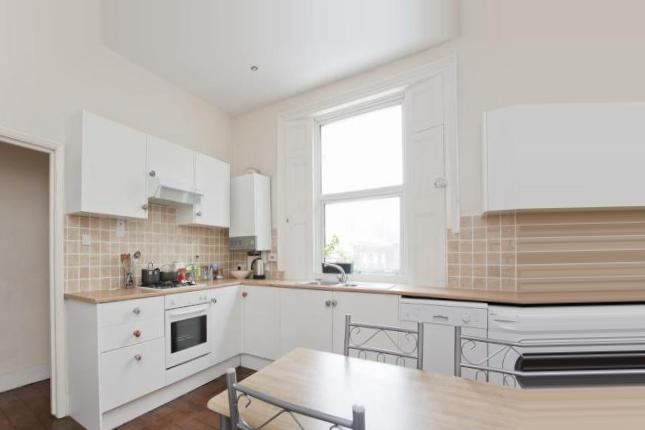

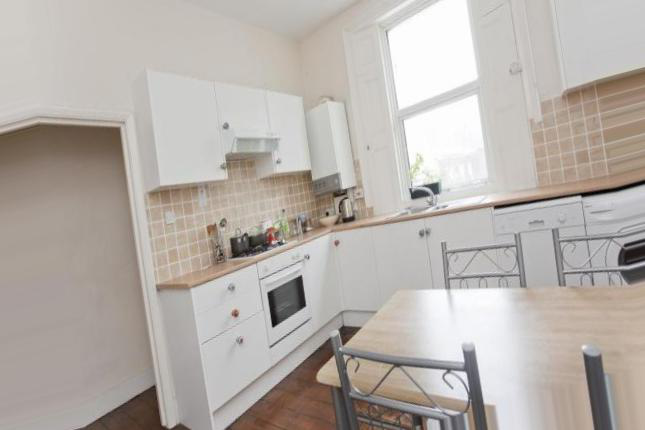

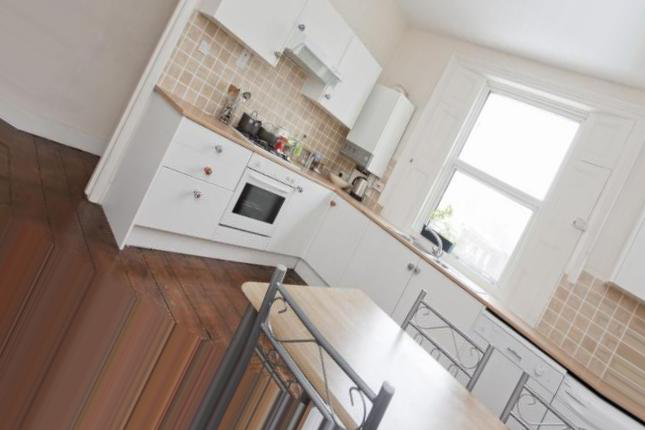

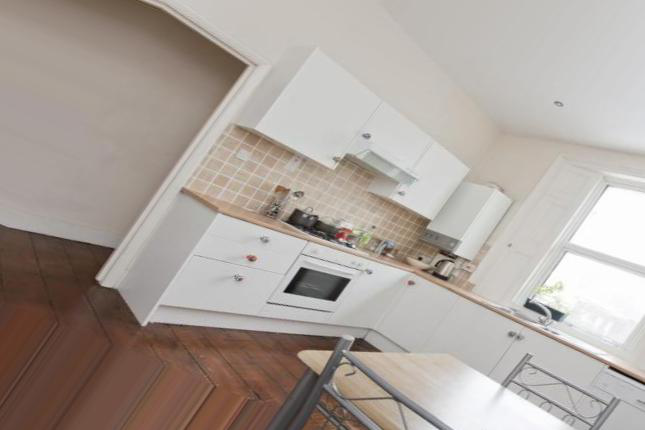

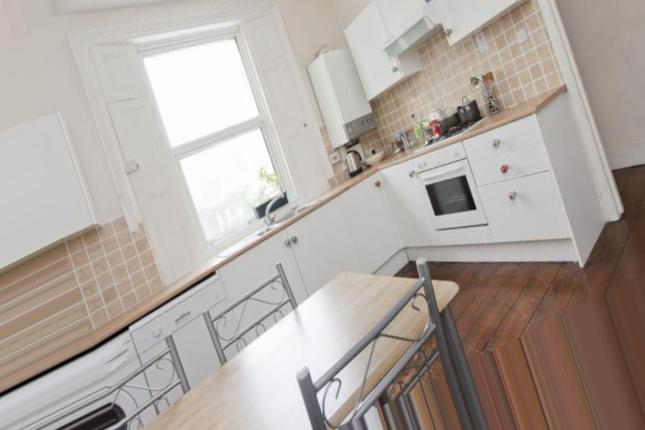

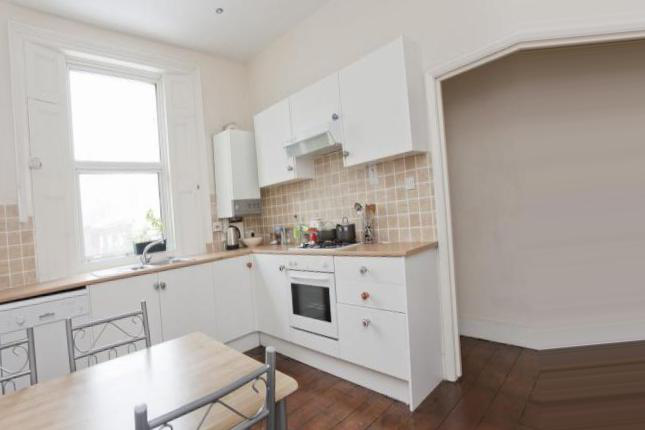

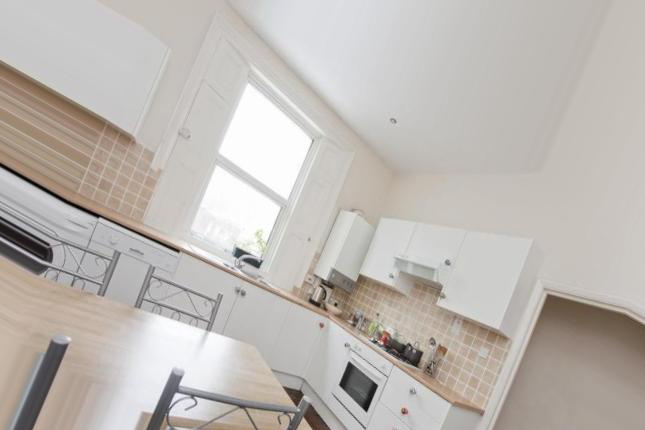

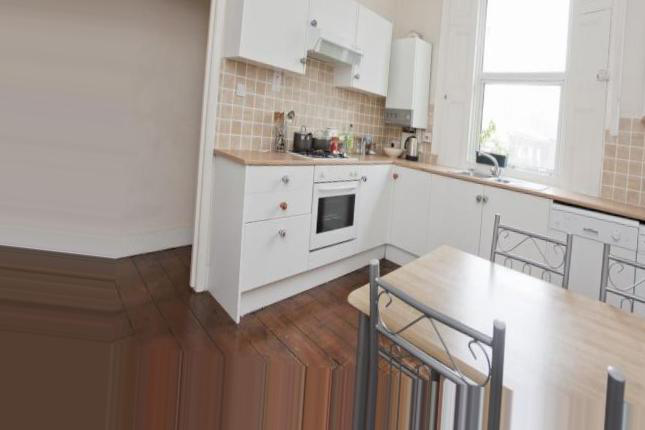

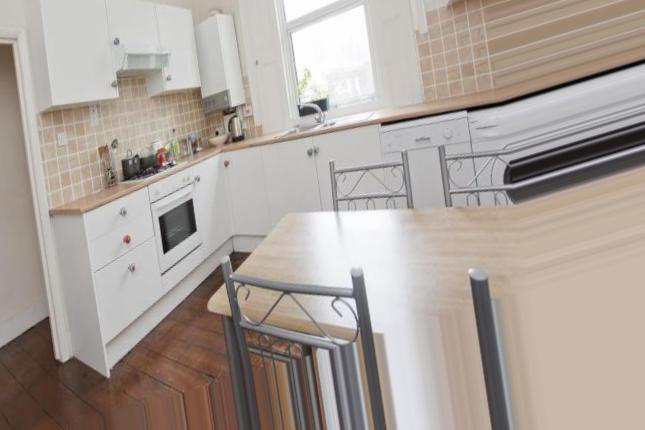

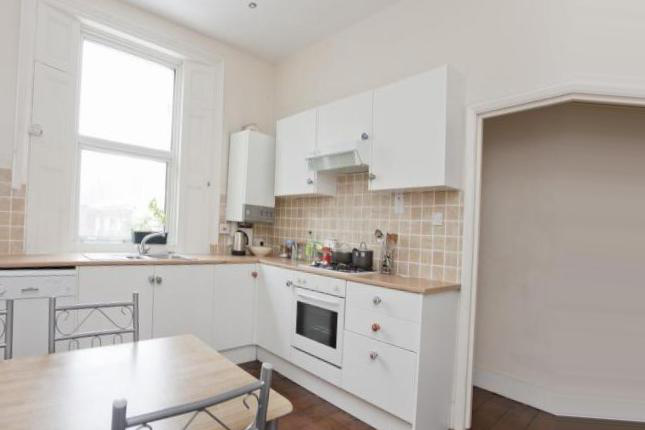

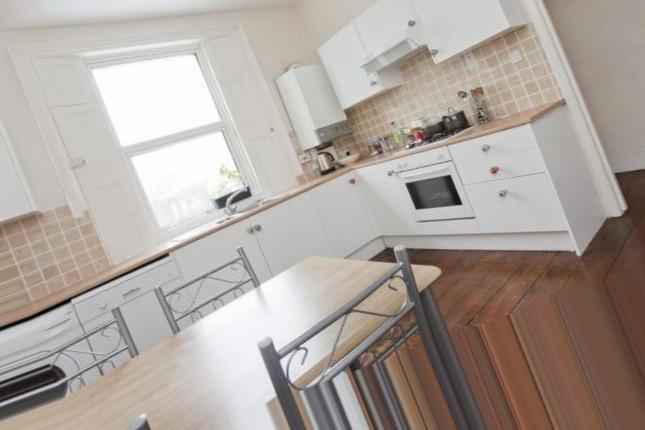

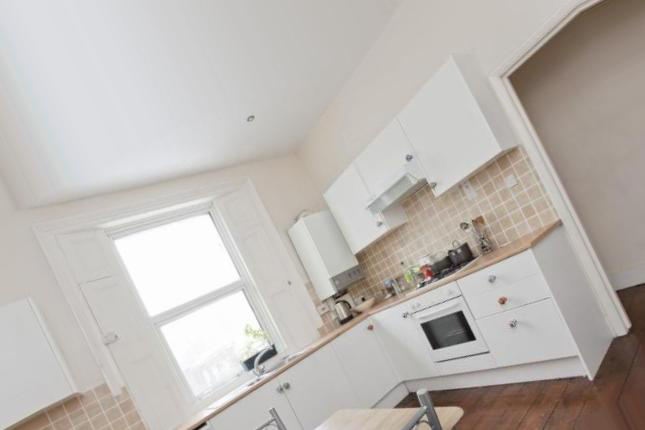

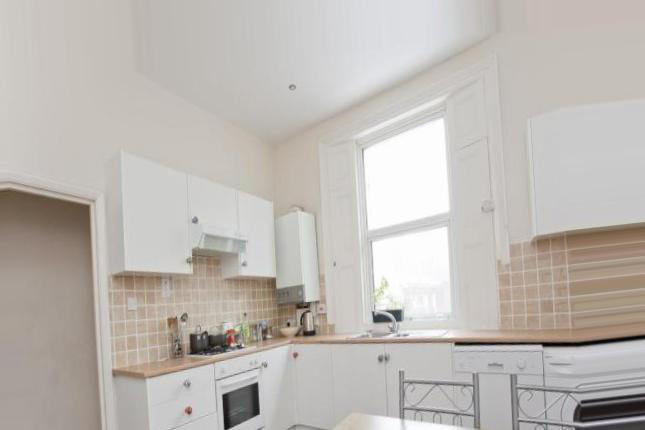

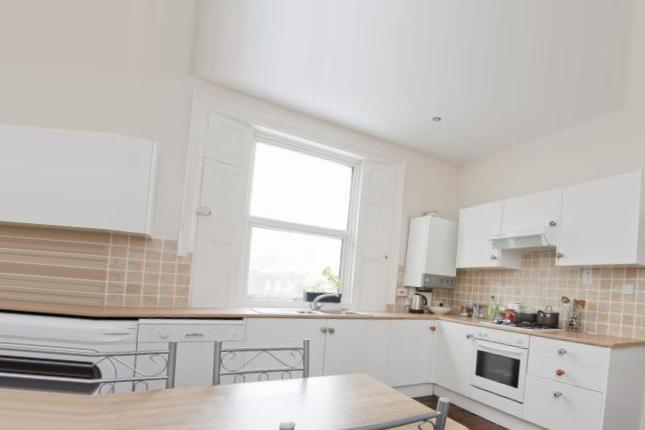

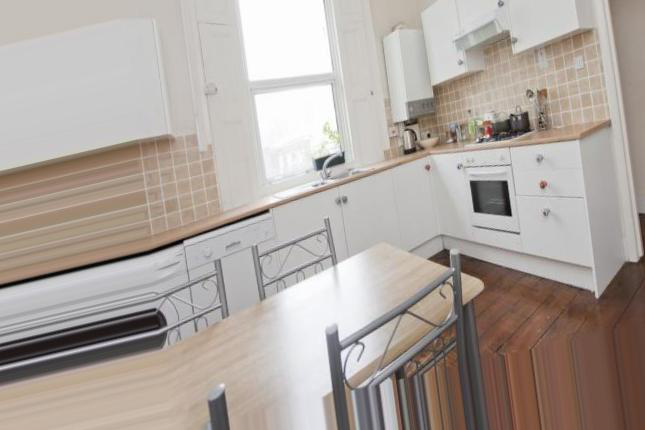

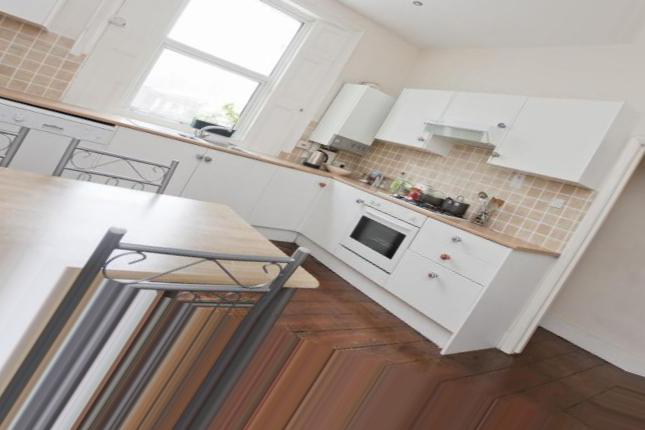

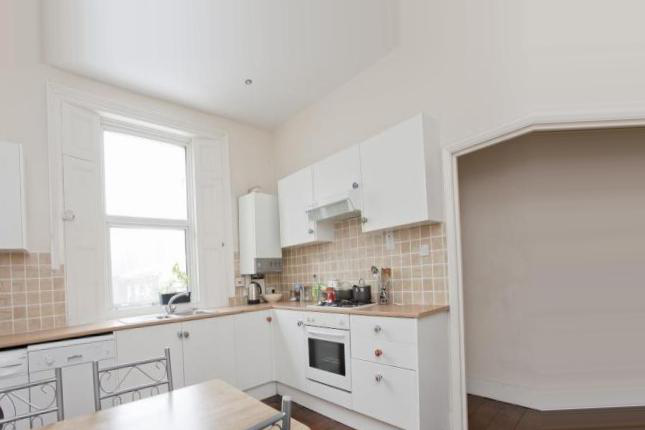

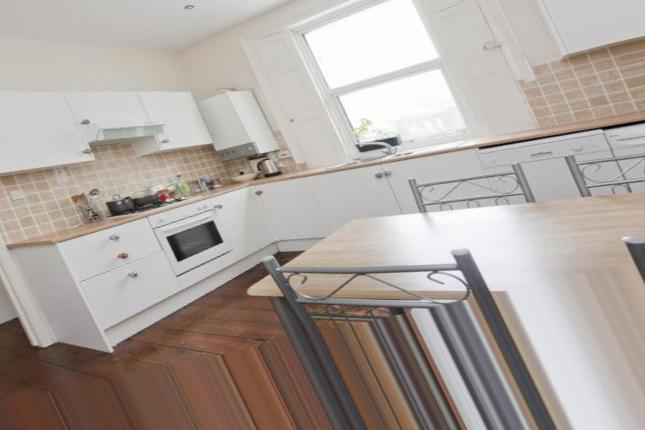

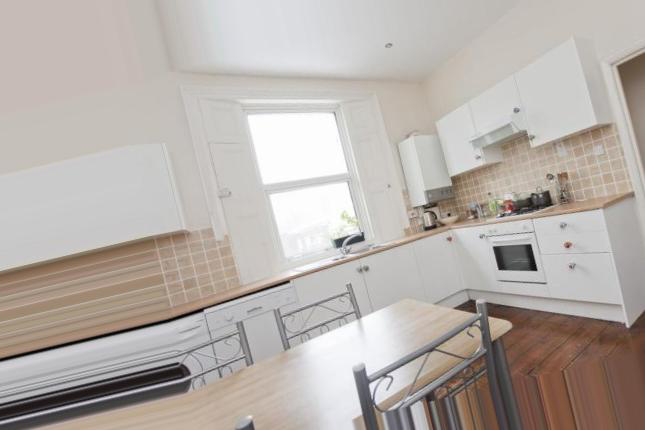

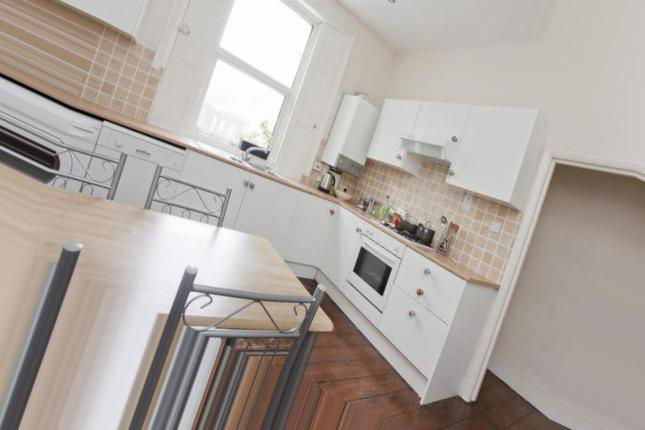

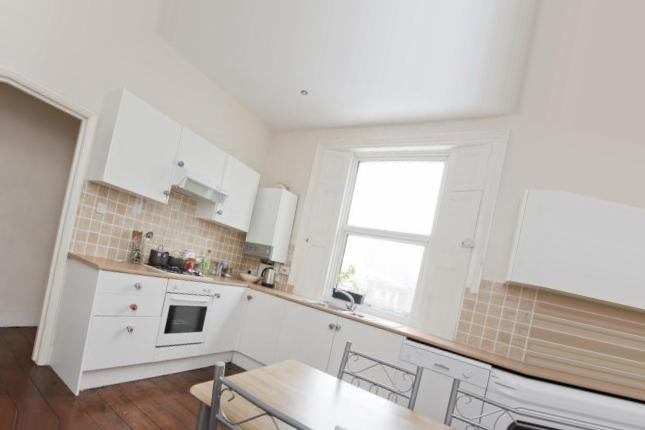

In [12]:
for file in os.listdir('Image_Check'):
    filename = 'Image_Check/' + file
    image = load_img(filename)
    image

In [14]:
train_dir = 'Train/'
test_dir = 'Test/'

aug_train_dir = 'Aug_Train/'
aug_test_dir = 'Aug_Test/'

target_image_height = 224
target_image_width = 224

batch_size = 32
random_seed = 1234

In [28]:
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(target_image_height, target_image_width), 
        batch_size=batch_size, 
        save_to_dir=aug_train_dir,
        seed=random_seed)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(target_image_height, target_image_width),
        batch_size=batch_size,
        save_to_dir=aug_test_dir,
        seed=random_seed,
        shuffle=False
        )

Found 2148 images belonging to 3 classes.
Found 715 images belonging to 3 classes.


### 2) Building a very simple sequential model to use as a baseline

In [26]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')
    plt.savefig('accuracy.png')
    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.savefig('loss.png')

In [21]:
# Use few filters and neurons to control for overfitting
base_model = Sequential()
base_model.add(Conv2D(32, (3, 3), input_shape=(target_image_height, target_image_width, 3), padding='same'))
base_model.add(Activation('relu'))
base_model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

base_model.add(Conv2D(32, (3, 3)))
base_model.add(Activation('relu'))
base_model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

base_model.add(Conv2D(64, (3, 3)))
base_model.add(Activation('relu'))
base_model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

base_model.add(Flatten())
base_model.add(Dense(64))
base_model.add(Activation('relu'))
base_model.add(Dropout(0.5))
base_model.add(Dense(3))
base_model.add(Activation('softmax'))

base_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [24]:
hist = base_model.fit_generator(
        train_generator,
        steps_per_epoch=1000 // batch_size,
        epochs=10,
        validation_data=test_generator,
        validation_steps=600 // batch_size)

Epoch 1/10
31/31 [==============================] - 166s 5s/step - loss: 0.9076 - acc: 0.5665 - val_loss: 0.8665 - val_acc: 0.5833
Epoch 2/10
31/31 [==============================] - 155s 5s/step - loss: 0.8800 - acc: 0.5635 - val_loss: 0.8970 - val_acc: 0.5747
Epoch 3/10
31/31 [==============================] - 155s 5s/step - loss: 0.9211 - acc: 0.5456 - val_loss: 1.0351 - val_acc: 0.5747
Epoch 4/10
31/31 [==============================] - 158s 5s/step - loss: 0.8718 - acc: 0.5694 - val_loss: 0.8379 - val_acc: 0.5885
Epoch 5/10
31/31 [==============================] - 178s 6s/step - loss: 0.8541 - acc: 0.5958 - val_loss: 0.8371 - val_acc: 0.5764
Epoch 6/10
31/31 [==============================] - 162s 5s/step - loss: 0.8501 - acc: 0.5815 - val_loss: 0.8441 - val_acc: 0.5816
Epoch 7/10
31/31 [==============================] - 169s 5s/step - loss: 0.8848 - acc: 0.5675 - val_loss: 0.8364 - val_acc: 0.5729
Epoch 8/10
31/31 [==============================] - 164s 5s/step - loss: 0.8832 - a

In [25]:
base_model.save_weights('base_model_weights.h5') 

In [31]:
plot_training(hist)

TypeError: 'ImageDataGenerator' object is not an iterator

In [4]:
def get_nb_files(directory):
    """Get number of files by searching directory recursively"""
    if not os.path.exists(directory):
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
            cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt

In [5]:
def add_new_last_layer(base_model, nb_classes):

    """Add last layer to the convnet
       Args:
        base_model: keras model excluding top
        nb_classes: # of classes
    Returns:
        new keras model with last layer
    """
    x = base_model.output
    x = MaxPooling2D((3, 3), border_mode='same', strides=1, name='max_pool')(x)
    x = Dropout(0.2, seed=1234)(x)
    x = Flatten()(x)
#     x = Dense(100, activation='relu', name='fc1')(x)
    predictions = Dense(3, activation='softmax')(x)
    model = Model(input=base_model.input, output=predictions)
    return model


In [6]:
def setup_to_transfer_learn(model, base_model):
    """Freeze all layers and compile the model"""
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [7]:
nb_classes = len(glob.glob(train_dir + "/*"))
nb_classes
nb_train_samples = get_nb_files(train_dir)
nb_train_samples
nb_test_samples = get_nb_files(test_dir)
nb_test_samples

3

2148

715

In [8]:
if(K.image_dim_ordering() == 'th'):
    input_tensor = Input(shape=(3, 224, 224))
else:
    input_tensor = Input(shape=(224, 224, 3))

In [9]:
base_model = MobileNet(input_tensor = input_tensor, input_shape=(224, 224, 3), weights='imagenet', include_top=False)
model = add_new_last_layer(base_model, nb_classes)
# base_model.summary()

C:\Users\ADETOLA\Anaconda3\envs\camsparknn\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((3, 3), strides=1, name="max_pool", padding="same")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\ADETOLA\Anaconda3\envs\camsparknn\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  app.launch_new_instance()


In [10]:
train_generator.image_shape
test_generator.image_shape

(224, 224, 3)

(224, 224, 3)

In [ ]:
setup_to_transfer_learn(model, base_model)
history_tl = model.fit_generator(train_generator,
                                   samples_per_epoch=nb_train_samples,
                                 nb_epoch=1,
                                   validation_data=test_generator,
                                )
#                                   nb_val_samples=nb_test_samples) 



C:\Users\ADETOLA\Anaconda3\envs\camsparknn\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
C:\Users\ADETOLA\Anaconda3\envs\camsparknn\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., steps_per_epoch=71, epochs=1)`
  """


Epoch 1/1
 4/71 [>.............................] - ETA: 17:27 - loss: 6.1786 - acc: 0.6167

In [ ]:
model.save(output_model_file)

In [ ]:
__

In [ ]:
plot_training(history_tl)